# Analysis

> Recovering event timings for synchronising data

In [ ]:
#| default_exp analysis

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#|hide
#|export
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [ ]:
#| hide
# Define style
sns.set()
sns.set_context('talk')
sns.set_style('ticks')

After recording data, event signals are present as pulses of varying duration on a single channel.

However, in order to be able to analyse the recorded signals synchronised to the events, it is necessary to recover the exact timings of the onsets of each discrete event type.

## Loading data
Data should be loaded as necessary following recording. The event synchronisation channel recording should be part of this data.

Here is a simple example loading oscilloscope data recorded from the output of the device while each event type is triggered in turn.

In [ ]:
# Load example data - recorded signals using oscilloscope
data = np.loadtxt('./example_data/all_triggers.csv', delimiter=',', skiprows=2, usecols=[0,1])
samplerate = 250 # Hz

# Split data into time and voltage
t = data[:, 0]
v = data[:, 1]

t = t + 0.5 #|hide_line

In this example, the sample data is recorded at 250Hz and saved as a CSV file with a two-line header and two columns. The first column is the time, the second is the recorded voltage, i.e. the event signal data.

This sample data is visualised below.

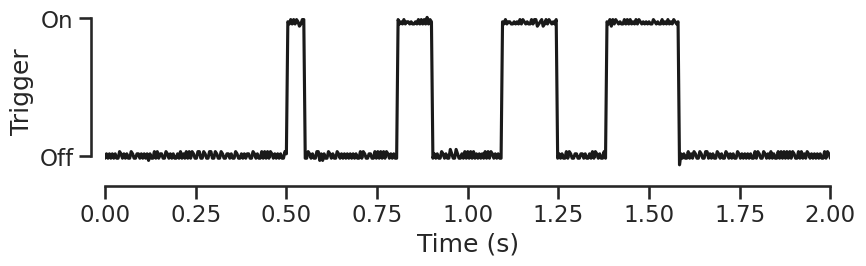

In [ ]:
#|echo: false
# Plot figure
fig, ax = plt.subplots(figsize=(9,3))

ax.plot(t, v, 'k')

ax.set(
    xlabel = 'Time (s)',
    ylabel = 'Trigger',
    xlim = (0, 2),
    yticks = (0, 0.5),
    yticklabels = ['Off', 'On']
)

sns.despine(ax=ax, offset=10, trim=True)
fig.tight_layout()

## Recovering event timings
In order to synchronise the recorded signals to the behavioural events, we need to recover the exact timings of each discrete event type.

The package includes a function that allows us to determine exact event timings for each event type from the single-channel data of variable duration pulses.

In [ ]:
#| export
# Process data
def getEvents(data: np.ndarray, # Single-channel data; 1 x t array
              samplerate: int, # Recording sample rate (Hz)
              eventIDs: list = None # List of unique event IDs
             )->np.ndarray: # Event timings; n x t array
    '''
    Recover discrete event timings from single-channel data
    '''
    
    # If no event IDs defined, use defaults
    if eventIDs is None:
       eventIDs = [5, 10, 15, 20] # Set default event IDs (start, end, event1, event2)
    
    # Get pulse widths
    pulsewidths = np.array(eventIDs)
    pulsewidths = pulsewidths * 10 # Convert to ms

    # Get number of events
    num_events = len(eventIDs)

    # Create empty array - n x t
    events = np.zeros((num_events, len(data)))

    # Define threshold - 0.75x max value
    threshold = 0.75 * np.max(data)

    # Define cutoffs - in number of samples; expect high 5ms before, low 5ms after expected end
    cutoffs = ((pulsewidths - 5)/1000) * samplerate # Point 5ms before expected end of pulse

    # Sort cutoffs in descending order and get sorted order
    cutoffs_sorted = np.sort(cutoffs) 
    cutoffs_sorted = cutoffs_sorted[::-1]
    cutoffs_args = np.argsort(cutoffs)
    cutoffs_args = cutoffs_args[::-1]

    # Loop over points in data array
    idx = 0
    while idx < len(data):
        # Get current datapoint
        d = data[idx]

        # If point > threshold: find next point below threshold
        if d > threshold:
            # Reset state
            window = 1
            end_found = False

            # Continue until value drops below threshold or data ends
            while (idx + window <= len(data) and end_found == False):
                # Check if dropped below threshold
                if data[idx + window] < threshold:
                    end_found = True

                window += 1

            # If end found: assign to event type
            if end_found:
                # Iterate over sorted cutoffs
                event_assigned = False # Avoid assigning to multiple events
                for cutoff_id, cutoff in enumerate(cutoffs_sorted):
                    # If greater than expected, assign to event type (unsorted)
                    if window > cutoff and event_assigned == False:
                        events[cutoffs_args[cutoff_id], idx] = 1
                        event_assigned = True

                # Move current point to end of window
                idx = idx + window

        # Move to next datapoint
        idx += 1
        
    # Return events list
    return events

The input data is provided as a one-dimensional `numpy.ndarray`. This corresponds to the recorded output signal at every timepoint.

The `samplerate` parameter is the sample rate of the recording system in Hz. This allows the expected duration of pulses in time to be linked to the expected number of samples in a given pulse.

The `eventIDs` parameter allows user-defined events to be recovered from the data. This is not necessary if using the simple, pre-defined events (`start`, `end`, `event1` and `event2`). Using this option is described in further detail below.

In [ ]:
# Recover event data
events = getEvents(v, samplerate)

This function returns a two-dimensional `numpy.ndarray`. Each row corresponds to an event type in the order `start`, `end`, `event1`, `event2`. Each column corresponds to a single timepoint in the original recording.

The recovered event signals will be `0` everywhere except for at the timepoints where that event type occured, where they will be `1`. 

In this way, we recover the precise event onset times for each individual event type from the single-channel variable duration pulse data.

The event data can then be plotted to verify that we have recovered the exact event timings.

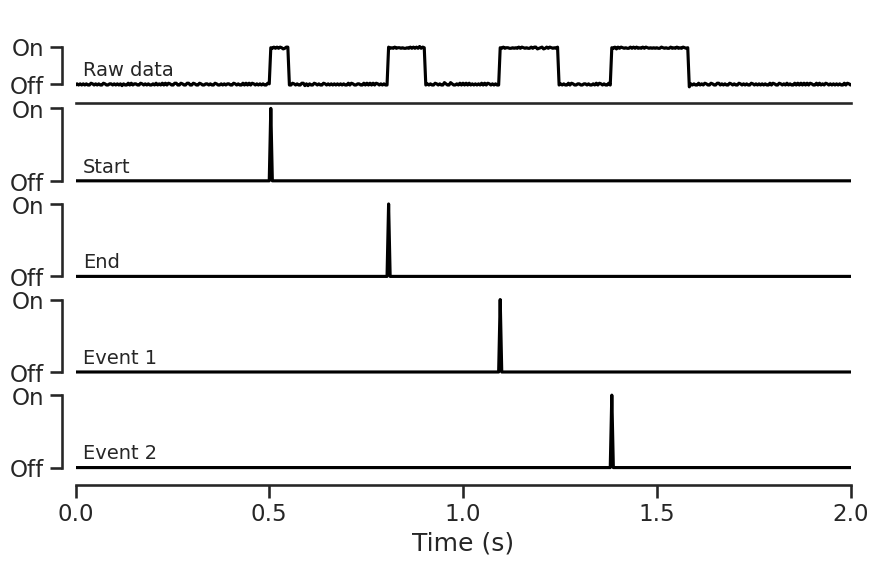

In [ ]:
# Plot results
fig, ax = plt.subplots(5, 1, sharex='row', figsize=(10,6))

ax[0].plot(t, v)
ax[1].plot(t, events[0,:])
ax[2].plot(t, events[1,:])
ax[3].plot(t, events[2,:])
ax[4].plot(t, events[3,:])

labels = ['Raw data', 'Start', 'End', 'Event 1', 'Event 2']  #|hide_line

for idx, ax_ in enumerate(ax): #|hide_line
    ax_.get_lines()[0].set_color("black") #|hide_line
    
    sns.despine(ax=ax_, offset=10, trim=True) #|hide_line
    
    ax_.set( #|hide_line
        yticks = (0, 1), #|hide_line
        yticklabels = ['Off', 'On'], #|hide_line
        xlim = (0, 2) #|hide_line
    ) #|hide_line
    
    ax_.text( #|hide_line
        0.02, 0.2, #|hide_line
        f"{labels[idx]}", #|hide_line
        ha='left', #|hide_line
        va='center', #|hide_line
        fontsize=14 #|hide_line
    ) #|hide_line
    
for ax_ in ax[:-1]: #|hide_line
    ax_.get_xaxis().set_visible(False) #|hide_line
    ax_.spines['bottom'].set_visible(False) #|hide_line
    
ax[-1].set( #|hide_line
    xlabel = 'Time (s)', #|hide_line
) #|hide_line

ax[0].set( #|hide_line
    yticks = (0, np.max(v)), #|hide_line
    yticklabels = ['Off', 'On'], #|hide_line
) #|hide_line
sns.despine(ax=ax[0], offset=10, trim=True) #|hide_line

## User-defined events

If using user-defined events, event timing can be recovered by passing a list of unique event IDs to the optional `eventIDs` parameter of `getEvents()`.

In [ ]:
# Define event IDs
END = 1
EVENT1 = 2
EVENT2 = 3
CONDITION1 = 4
CONDITION2 = 5

# Create list of event IDs
eventIDs = [END, EVENT1, EVENT2, CONDITION1, CONDITION2]

The `getEvents()` function can then be used as before, now taking the event IDs as an input.

In [ ]:
#|output: false
# Recover event data using user-defined event IDs
events = getEvents(v, samplerate, eventIDs=eventIDs)

This function returns a two-dimensional `numpy.ndarray`. Each row corresponds to an event type. The order of events is defined by the ordering in the input `eventIDs` list, i.e. the *i*th row of the `events` array corresponds to occurences of the *i*th event in `eventIDs` list.

In this example, the `events` array will contain five rows in the order `END`, `EVENT1`, `EVENT2`, `CONDITION1`, `CONDITION2`.

## Data analysis
This produces an array with `1` at the onset of each event type.

This allows for recorded signals to be easily extracted around these event signals, allowing windowing, averaging, etc.

By recovering and separating discrete event types, this allows for multiple different discrete event types to be encoded using a single input channel on the recording system.

This provides a straightforward system for performing synchronisation of recorded signals to complex behavioural tasks with arbitrary events.

::: {.dark-mode}
![Oxford Neural Interfacing 2023](oni.png)
:::

::: {.light-mode}
![Oxford Neural Interfacing 2023](oni_blue.png)
:::